# Title: Attack Graph Metrics

## Purpose: Snippets to review published AG Metrics
## Author: \author@mjz


## Overview / BLUF


Boromir is our attack graph framework integrated into PKB to provide end to end security benchmarking. 

The example run of Boromir shown here to demonstrate:

In [1]:

%%bash
/opt/projects/diss/py-mulval/src/run_boromir.py

{'metric_name': 'metf_ml', 'metric_unit': 'effs', 'metric_summary': '"Determines the survival function complement from reliability engineering.', 'cite_key': 'Ortalo1999', 'citation': 'Rodolphe Ortalo, Yves Deswarte, and Mohamed Kaâniche. 1999. Experimenting with quantitative evaluation tools for monitoring operational security. IEEE Transactions on Software Engineering 25, 5 (1999), 633–650.\n', 'metric_usage': 'Accepts an attack graph and the node to start from, or looks for the origin if no node provided'}
py_mulval.metrics

52.033500000000004
103.06700000000001
153.267
153.46699999999998
153.46699999999998
{('0', '13', '5', '3', '1'): 153.46699999999998}
52.033500000000004
103.06700000000001
153.2672
203.4672
203.66719999999998
203.66719999999998
{('0', '13', '5', '3', '1'): 153.46699999999998, ('0', '13', '8', '5', '3', '1'): 203.66719999999998}
[[2.22222222e-01 4.44444444e-01 3.33333333e-01 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 2.85714286e-01 7.14285714e-01 0.00000000

2020-03-29 18:14:55,216 01dc9dd0 MainThread INFO     Verbose logging to: /tmp/mulpy/runs/01dc9dd0/boromir.log
2020-03-29 18:14:55,217 01dc9dd0 MainThread INFO     PerfKitBenchmarker version: unknown
2020-03-29 18:14:55,217 01dc9dd0 MainThread INFO     Flag values:

2020-03-29 18:14:55,230 01dc9dd0 MainThread INFO     Running: ssh-keygen -t rsa -N  -m PEM -q -f /tmp/mulpy/runs/01dc9dd0/py_mulval_keyfile
2020-03-29 18:14:55,328 01dc9dd0 MainThread INFO     Setting --max_concurrent_threads=200.
2020-03-29 18:14:55,410 01dc9dd0 MainThread metf_tm(1/6) INFO     Provisioning resources for benchmark metf_tm
2020-03-29 18:14:55,410 01dc9dd0 MainThread metf_tm(1/6) INFO     Preparing benchmark metf_tm
2020-03-29 18:14:55,417 01dc9dd0 MainThread metf_tm(1/6) INFO     Running benchmark metf_tm
2020-03-29 18:14:55,424 01dc9dd0 MainThread metf_tm(1/6) INFO     Cleaning up benchmark metf_tm
2020-03-29 18:14:55,424 01dc9dd0 MainThread metf_tm(1/6) INFO     Tearing down resources for benchmark metf_tm

The remainder of this notebook shows how the SECMET library can be used to model and evaluate different security metrics

In [73]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import sys
import networkx as nx
import graphviz
import pprint

import IPython.display

import numpy as np
from itertools import chain

import numpy as np
import scipy.stats as st
import scipy.special

import bokeh.io
import bokeh.plotting
import bokeh.application
import bokeh.application.handlers
bokeh.io.output_notebook()

py_mulval_path = r'/opt/projects/diss/py-mulval/src'
sys.path.append(py_mulval_path)

notebook_url = 'localhost:8888'

import py_mulval.metrics
import py_mulval.attack_graph as attack_graph
from py_mulval.attack_graph import AttackGraph

from py_mulval import flags
FLAGS = flags.FLAGS
FLAGS([sys.argv[0]]) # dont expect cli args from jupyter

Loading BokehJS ...

['/opt/projects/diss/jupyter_nbs/py36/lib/python3.6/site-packages/ipykernel_launcher.py']

In [74]:
# Show an attack graph in this notebook
def plot_ag(ag, title=None):
    A = nx.nx_agraph.to_agraph(ag)
    if title:
        A.graph_attr.update(label=title, labelloc='top', labeljust='center', fontsize=24)
    # A.layout('dot', args='-Nfontsize=10 -Nwidth=".2" -Nheight=".2" -Nmargin=0 -Gfontsize=8')
    args = """
    -Gsize=17
    -Nfontname=Roboto
    -Efontname=Roboto
    -Nfontsize=14
    -Efontsize=14
    """
    A.layout('dot', args=args )
    # A.draw(self.outputDir + '/' + outfilename)
    A.draw()
    # plt.show()
    return graphviz.Source(A.to_string())

# Bokeh interactive plotting
# source: http://bois.caltech.edu/dist_stories/
def distribution_plot_app(x_min=None, x_max=None, scipy_dist=None,
    transform=None, custom_pdf=None, custom_pmf=None, custom_cdf=None, 
    params=None, n=400, plot_height=200, plot_width=300, x_axis_label='x', 
    title=None):
    """
    Build interactive Bokeh app displaying a univariate
    probability distribution.

    Parameters
    ----------
    x_min : float
        Minimum value that the random variable can take in plots.
    x_max : float
        Maximum value that the random variable can take in plots.
    scipy_dist : scipy.stats distribution
        Distribution to use in plotting.
    transform : function or None (default)
        A function of call signature `transform(*params)` that takes
        a tuple or Numpy array of parameters and returns a tuple of
        the same length with transformed parameters.
    custom_pdf : function
        Function with call signature f(x, *params) that computes the
        PDF of a distribution.
    custom_pmf : function    
        Function with call signature f(x, *params) that computes the
        PDF of a distribution.
    custom_cdf : function
        Function with call signature F(x, *params) that computes the
        CDF of a distribution.
    params : list of dicts
        A list of parameter specifications. Each entry in the list gives
        specifications for a parameter of the distribution stored as a
        dictionary. Each dictionary must have the following keys.
            name : str, name of the parameter
            start : float, starting point of slider for parameter (the
                smallest allowed value of the parameter)
            end : float, ending point of slider for parameter (the
                largest allowed value of the parameter)
            value : float, the value of the parameter that the slider
                takes initially. Must be between start and end.
            step : float, the step size for the slider
    n : int, default 400
        Number of points to use in making plots of PDF and CDF for 
        continuous distributions. This should be large enough to give
        smooth plots.
    plot_height : int, default 200
        Height of plots.
    plot_width : int, default 300
        Width of plots.
    x_axis_label : str, default 'x'
        Label for x-axis.
    title : str, default None
        Title to be displayed above the PDF or PMF plot.

    Returns
    -------
    output : Bokeh app
        An app to visualize the PDF/PMF and CDF. It can be displayed
        with bokeh.io.show(). If it is displayed in a notebook, the
        notebook_url kwarg should be specified.
    """
    if None in [x_min, x_max]:
        raise RuntimeError('`x_min` and `x_max` must be specified.')

    if scipy_dist is None:
        fun_c = custom_cdf
        if (custom_pdf is None and custom_pmf is None) or custom_cdf is None:
            raise RuntimeError('For custom distributions, both PDF/PMF and'
                                + ' CDF must be specified.')
        if custom_pdf is not None and custom_pmf is not None:
            raise RuntimeError('Can only specify custom PMF or PDF.')
        if custom_pmf is None:
            discrete = False
            fun_p = custom_pdf
        else:
            discrete = True
            fun_p = custom_pmf
    elif (   custom_pdf is not None 
          or custom_pmf is not None
          or custom_cdf is not None):
        raise RuntimeError(
            'Can only specify either custom or scipy distribution.')
    else:
        fun_c = scipy_dist.cdf
        if hasattr(scipy_dist, 'pmf'):
            discrete = True
            fun_p = scipy_dist.pmf
        else:
            discrete = False
            fun_p = scipy_dist.pdf
                
    if discrete:
        p_y_axis_label = 'PMF'
    else:
        p_y_axis_label = 'PDF'

    if params is None:
        raise RuntimeError('`params` must be specified.')
        

    def _plot_app(doc):
        p_p = bokeh.plotting.figure(plot_height=plot_height,
                                    plot_width=plot_width,
                                    x_axis_label=x_axis_label,
                                    y_axis_label=p_y_axis_label,
                                    title=title)
        p_c = bokeh.plotting.figure(plot_height=plot_height,
                                    plot_width=plot_width,
                                    x_axis_label=x_axis_label,
                                    y_axis_label='CDF')

        # Link the axes
        p_c.x_range = p_p.x_range

        # Make sure CDF y_range is zero to one
        p_c.y_range = bokeh.models.Range1d(-0.05, 1.05)

        # Make array of parameter values
        param_vals = np.array([param['value'] for param in params])
        if transform is not None:
            param_vals = transform(*param_vals)

        # Set up data for plot
        if discrete:
            x = np.arange(int(np.ceil(x_min)), 
                          int(np.floor(x_max))+1)
            x_size = x[-1] - x[0]
            x_c = np.empty(2*len(x))
            x_c[::2] = x
            x_c[1::2] = x
            x_c = np.concatenate(((max(x[0] - 0.05*x_size, x[0] - 0.95),), 
                                  x_c,
                                  (min(x[-1] + 0.05*x_size, x[-1] + 0.95),)))
            x_cdf = np.concatenate(((x_c[0],), x))
        else:
            x = np.linspace(x_min, x_max, n)
            x_c = x_cdf = x

        # Compute PDF and CDF
        y_p = fun_p(x, *param_vals)
        y_c = fun_c(x_cdf, *param_vals)
        if discrete:
            y_c_plot = np.empty_like(x_c)
            y_c_plot[::2] = y_c
            y_c_plot[1::2] = y_c
            y_c = y_c_plot

        # Set up data sources
        source_p = bokeh.models.ColumnDataSource(data={'x': x,
                                                       'y_p': y_p})
        source_c = bokeh.models.ColumnDataSource(data={'x': x_c, 
                                                       'y_c': y_c})

        # Plot PDF and CDF
        p_c.line('x', 'y_c', source=source_c, line_width=2)
        if discrete:
            p_p.circle('x', 'y_p', source=source_p, size=5)
            p_p.segment(x0='x',
                        x1='x',
                        y0=0, 
                        y1='y_p', 
                        source=source_p, 
                        line_width=2)
        else:
            p_p.line('x', 'y_p', source=source_p, line_width=2)
            
        
        def _callback(attr, old, new):
            param_vals = tuple([slider.value for slider in sliders])
            if transform is not None:
                param_vals = transform(*param_vals)
            
            # Compute PDF and CDF
            source_p.data['y_p'] = fun_p(x, *param_vals)
            y_c = fun_c(x_cdf, *param_vals)
            if discrete:
                y_c_plot = np.empty_like(x_c)
                y_c_plot[::2] = y_c
                y_c_plot[1::2] = y_c
                y_c = y_c_plot
            source_c.data['y_c'] = y_c

        sliders = [bokeh.models.Slider(start=param['start'],
                                       end=param['end'],
                                       value=param['value'],
                                       step=param['step'],
                                       title=param['name'])
                            for param in params]
        for slider in sliders:
            slider.on_change('value', _callback)

        # Add the plot to the app
        widgets = bokeh.layouts.widgetbox(sliders)
        grid = bokeh.layouts.gridplot([p_p, p_c], ncols=2)
        doc.add_root(bokeh.layouts.column(widgets, grid))

    handler = bokeh.application.handlers.FunctionHandler(_plot_app)
    return bokeh.application.Application(handler)

### MulVal Attack Graph Example
This is the MulVal output that most of our metrics ingest as a 1st step:

In [75]:
!cat /opt/projects/diss/py-mulval/data/mulval_ag/small_enterprise/AttackGraph.dot

digraph G {
	1 [label="1:execCode(workStation,root):0",shape=diamond];
	2 [label="2:RULE 4 (Trojan horse installation):0",shape=ellipse];
	3 [label="3:accessFile(workStation,write,'/usr/local/share'):0",shape=diamond];
	4 [label="4:RULE 16 (NFS semantics):0",shape=ellipse];
	5 [label="5:accessFile(fileServer,write,'/export'):0",shape=diamond];
	6 [label="6:RULE 10 (execCode implies file access):0",shape=ellipse];
	7 [label="7:canAccessFile(fileServer,root,write,'/export'):1",shape=box];
	8 [label="8:execCode(fileServer,root):0",shape=diamond];
	9 [label="9:RULE 2 (remote exploit of a server program):0",shape=ellipse];
	10 [label="10:netAccess(fileServer,rpc,100005):0",shape=diamond];
	11 [label="11:RULE 5 (multi-hop access):0",shape=ellipse];
	12 [label="12:hacl(webServer,fileServer,rpc,100005):1",shape=box];
	13 [label="13:execCode(webServer,apache):0",shape=diamond];
	14 [label="14:RULE 2 (remote exploit of a server program):0",shape=ellipse];
	15 [label="15:netAccess(webServer,tcp,8

AttackGraph module can load this directy...

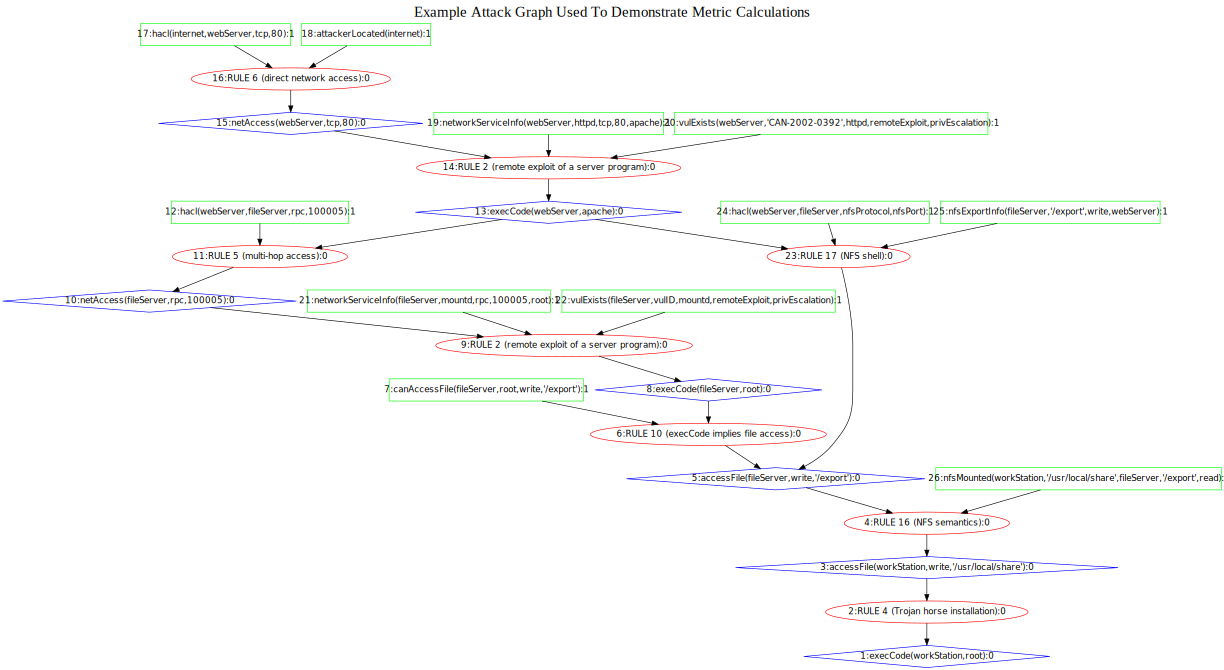

In [76]:
ag = AttackGraph()
ag.load_dot_file('/opt/projects/diss/py-mulval/data/mulval_ag/small_enterprise/AttackGraph.dot')
ag.name = 'small_enterprise'

plot_ag(ag, 'Example Attack Graph Used To Demonstrate Metric Calculations')

## Mean Time to Failure (mttf_dacier_1996)
Dacier cite{Dacier_1994, Dacier_1996}:

Dacier's privilege graph model assumes the probability $P$ to succeed in a given attack before time $t$ is described by an exponential distribution: 

$P(t) = 1-exp(-\lambda t)$ 

$P(t) = 1-e^{-\lambda t}$

Transition rate $\lambda$ estimates the effort and time, with mean time for an attack to succeed given by 

$\frac{1}{\lambda}$.

The mean time $T_j$ spent in state $j$ is :

$T_j = 1 / \sum\limits_{i\in out(j)}\lambda_{ji}$

... and the $MTTF_k$ is mean time to failure when $k$ is the initial state and $P_{k1}$ the conditional probability from state $k$ to state $1$:

$MTTF_k = T_k + \sum\limits_{1\in out(k)}P_{k1} \times MTTF_{k1} ~~ | ~~ P_{k1}=\lambda_{k1} \times T_k$


The shortest path is:

$\textbf{SP} = min(MTTF_k)$  for all possible paths


## Shortest Path (sp_dacier_1996)

$\textbf{SP} = min(MTTF_k)$  for all possible paths

In [77]:
params = [dict(name='λ', start=.0002, end=40, value=5, step=0.1)]
app = distribution_plot_app(x_min=0,
                            x_max=50,
                            scipy_dist=st.poisson,
                            params=params,
                            x_axis_label='n (# arravals)',
                            title='Poisson')
bokeh.io.show(app, notebook_url=notebook_url)

#### Discussion

Dacier chooses an exponential distribution to model the probability an attack will succeed before a given time $t$.

Exponential distributions model the arrival rate of a Poisson process. In a Poisson process, the assumption is that rare events occur with a rate $\lambda$ per unit time (1 week in our case, see below), and that rate is independent of time ("memoryless"). When an event occurs it is called an "arrival". The exponential distribution describes the average waiting time for an arrival from a Poisson process. 


The graph above shows the PMF and CDF of the Poisson process for different arrival rates.

The *PMF* (probability mass function) shows the probability (y-axis) that a discrete random variable is exactly equal to n (x-axis)

The *CDF* (cumulative distribution function) shows the probability (y-axis) the random variable will take a value less than or equal to n (x-axis)

The *PDF* (probability density function) is somewhat analogous to the PMF for continuous random variables, where the probability that the RV falls within some narrow interval on the x-axis $(x, \Delta x)$ is the area under the PDF curve between $f(x)$ and $f(\Delta x)$. *ie, y-axis is not probability here*

In [78]:
%load_ext latex_envs


The latex_envs module is not an IPython extension.


In [79]:
params = [dict(name='λ', start=0.0002, end=50, value=1, step=0.001)]
app = distribution_plot_app(0,
                            10,
                            st.expon,
                            params=params,
                            transform=lambda x: (0, 1/x), 
                            x_axis_label='t (time in weeks)',
                            title='Exponential')
bokeh.io.show(app, notebook_url=notebook_url)


The probability density of the exponential distribution with rate $\lambda$  and time $t$ is given by: 

$p(t) ~ = \lambda e^{-\lambda t}, ~~~ t \ge 0$

Remember in this context that $p(t)$ describes the probability of an attack being successful between times $t$ and some later time $t + \Delta$ as the area under the PDF curve, not the value $p(t)$. The CDF for time $t$ is the probability of a successful attack occuring before time $t$:


$
\begin{align*}
P(t) ~ &= ~ P(T \le t) \\
&= ~ \int_0^t \lambda e^{-\lambda s}ds \\
&= ~ -e^{-\lambda s} \big{|}_0^t \\
&= ~ 1 - e^{-\lambda t}
\end{align*}
$

Dacier defines the following attack success rates:
```
.0002 is quasi-instantanious
.02 is 1 hour
.2 is 1 day
1 is 1 week
5 is one month
50 is one year
```
... so the unit time in this case is 1 week. 

Arrival rate $\lambda$ is the expected number of arrivals per unit time (week), so inverting this rate gives the expected time between arrivals. In context, this is also the mean time to successfully exploit a specific vulnerability: 

$E(T) =\int_0^{\infty} t\lambda e^{-\lambda t} dt = \frac{1}{\lambda}$

<!-- $E(t) = \frac{1}{\lambda} = \lambda^{-1}$ -->


Text(0.5, 0.04, '$\\lambda =$1.3000')

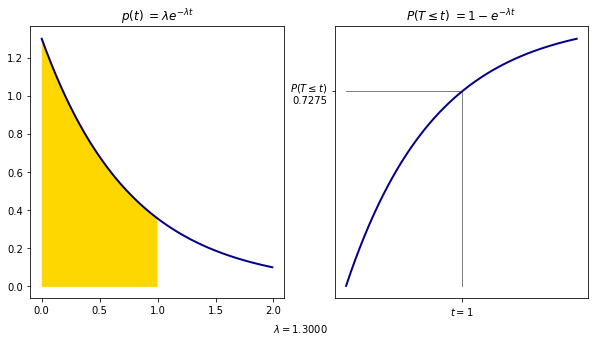

In [80]:



def f(lam, t):
    return lam * np.exp(-1*lam * t)

def P(lam, t):
    return 1 - np.exp(-1*lam*t)



# *** change lambda here ***
lamb = 1.3
# lamb = .75
# lamb = 50
# lamb = .0002
t = np.arange(0, 2, 0.01)
y_pdf = st.expon.pdf(t, scale=1/lamb)
y_cdf = st.expon.cdf(t, scale=1/lamb)


# print(f(lamb,0))
# print(f(lamb,1))
# print(P(lamb,1))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
w = np.arange(0, 1, 0.01)

ax[0].plot(t, y_pdf, color='darkblue', lw=2)
ax[0].fill_between(w, f(lamb, w),  color='gold')


ax[1].plot([0, 1], [P(lamb, 1), P(lamb, 1)], color='grey', lw=1)
ax[1].plot([1, 1], [0, P(lamb, 1)], color='grey', lw=1)
ax[1].plot(t, y_cdf, color='darkblue', lw=2)
ax[1].set_xticks([1])
ax[1].set_xticklabels( ['$t=1$'])
ax[1].set_yticks([P(lamb, 1)])
ax[1].set_yticklabels( ['$P(T\leq t)$\n{0:.{1}f}'.format(P(lamb, 1), 4)])


ax[0].title.set_text('$p(t) ~ = \lambda e^{-\lambda t}$')
ax[1].title.set_text('$P(T \leq t) ~ =1 - e^{-\lambda t}$')
fig.text(0.5, 0.04, '$\lambda =${0:.{1}f}'.format(lamb, 4), ha='center', va='center')

The plot above shows the exponential distribution for a fixed arrival rate $\lambda$. 

The shaded area under the PDF graph on the left for the given time (t=1) corresponds to the sum of failure rates up to that time, which is the y-axis value of the CDF function plotted on the right.

In Dacier's MTTF terms, this is the probability of a succesful attack before time $t$.

Below we show the PDF and CDF plots for different arrival rates:

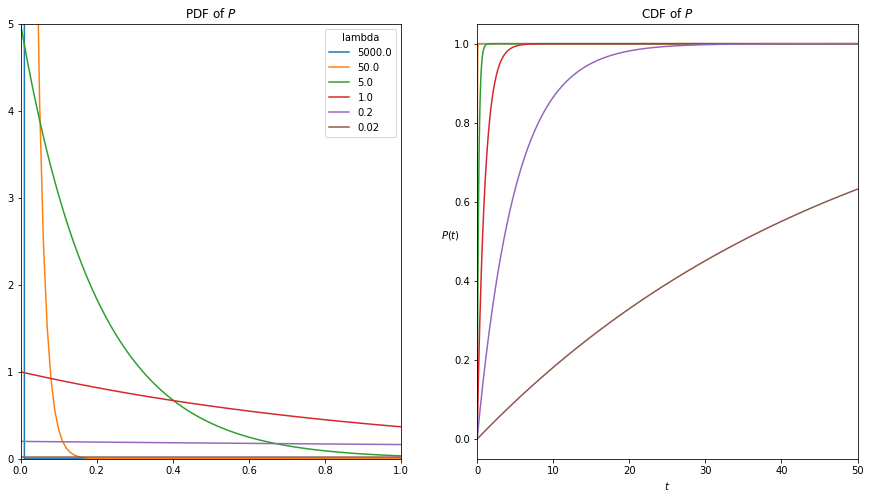

In [81]:


fig, ax = plt.subplots(1, 2, figsize=(15, 8))


# mean time to fire transitions:
# .0002 is quasi-instantanious
# .02 is 1 hour
# .2 1 day
# 1 is 1 week
# 5 is one month
# 50 is one year
rates = np.array([.0002, .02, .2, 1., 5., 50.]) 
lams = 1. / rates

t = np.arange(0, 50, 0.01)
# y = expon.pdf(t, scale=1/5)
for lam in lams:
    y_p = st.expon.pdf(t, scale=1/lam) 
    y =  st.expon.cdf(t, scale=1/lam)
    ax[0].plot(t, y_p, label=lam)
    ax[1].plot(t, y, label=lam)
plt.xlabel('$t$')
plt.ylabel('$P(t)$', rotation=False)
ax[0].set_ylim([0,5])
ax[0].set_xlim([0,1])
ax[0].legend(title='lambda')
ax[1].set_xlim([0,50])
# ax[1].legend(title='lambda')
# plt.title('CDF of $P$');

ax[0].title.set_text('PDF of $P$')
ax[1].title.set_text('CDF of $P$')

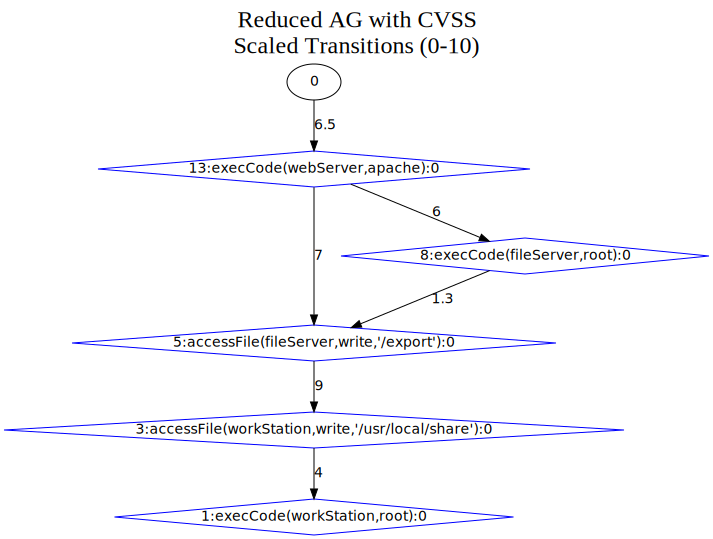

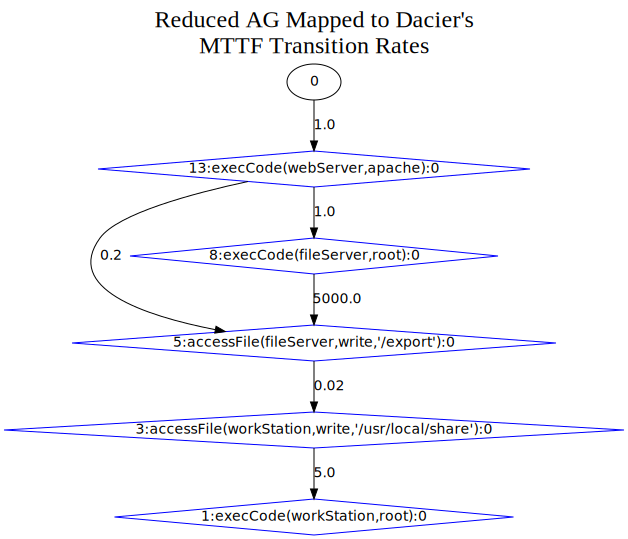

In [82]:

ag = AttackGraph()


ag.load_dot_file('/opt/projects/diss/py-mulval/data/mulval_ag/small_enterprise/AttackGraph.dot')
ag.name = 'small_enterprise'

# ag.load_score_dict('/opt/projects/diss/py-mulval/src/py_mulval/data/secmet/scoreDict_mttf.yml')
ag.load_score_dict('/opt/projects/diss/py-mulval/src/py_mulval/data/secmet/scoreDict.yml')
ag.PLOT_INTERMEDIATE_GRAPHS = False


reduced_ag = ag.getReducedGraph()
display(plot_ag(reduced_ag, 'Reduced AG with CVSS\nScaled Transitions (0-10)'))

# ag.map_scores = 'cvss2effort'
ag.map_scores = 'cvss2time'
ag.score_strategy = 'reliability'

reduced_ag = ag.getReducedGraph()
# print(reduced_ag.edges(data=True))
# print(reduced_ag.nodes(data=True))

display(plot_ag(reduced_ag, 'Reduced AG Mapped to Dacier\'s \nMTTF Transition Rates'))
# print(reduced_ag.edges(data=True))
# print(reduced_ag.nodes(data=True))




Above: Our example attack graph with CVSS scores mapped onto $\lambda$ arrival rates. 



In [83]:

    def mttf(A, n=None):
      """Calculates MTTF for a weighted DAG

      MTTF_k = T_k + sum_{L \in out edges}(P_{kL} x MTTF_kL)
                                  | P_kL = lambda_{kL} x T_k
                                  | T_k = 1/ lP_kL = lambda_{kL} x T_kambda_{out rates}

      :param A: attack graph
      :param n: node (start at origin if none)
      :return: MTTF
      """
      # init if not done already
      if not n:
        n = A.origin
      if 't_k' not in A.nodes[n].keys():
        scores = A.getOutEdgeValsForKey(n, 'score')  # edge scores should be (mapped) transition rates
        A.nodes[n]['t_k'] = 1 / sum(A.getOutEdgeValsForKey(n, 'score')) if scores else 0
      if 'mttf' not in A.nodes[n].keys():
          A.nodes[n]['mttf'] = None

      o_edges = [((u, v, k), e) for u, v, k, e in # grab our outbound edges
                 A.out_edges(n, keys=True, data=True)]

      p_sums = 0 # collects (P_{kL} x MTTF_kL) terms
      for (u, v, k), e in o_edges:
        if 'mttf' not in A.nodes[v].keys():
          A.nodes[v]['mttf'] = mttf(A, v)  # gets target mttf from far away
          A.nodes[v]['label'] = 'MTTF: {0:.{1}f}'.format(mttf(A,v), 4)
        P = A[u][v][k]['score'] * A.nodes[n]['t_k']  # P_kL = lambda_{kL} x T_k
        p_sums += P * A.nodes[v]['mttf']

      A.nodes[n]['mttf'] = A.nodes[n]['t_k'] + p_sums # mttf for this node
      return A.nodes[n]['mttf'] #, metadata



MTTF is defined recursively: 

$MTTF_k = T_k + \sum\limits_{1\in out(k)}P_{k1} \times MTTF_{k1} ~~ | ~~ P_{k1}=\lambda_{k1} \times T_k$

...so our implementation takes an attack graph and an optional vertex. If no vertex is given, the attacker origin is assumed. 

The recursion stops when no outbound edges are found, which indicates the target has been reached.


52.033500000000004


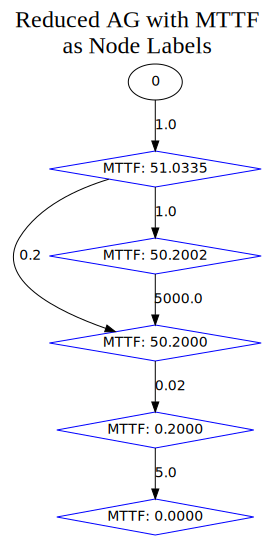

In [84]:
print(mttf(reduced_ag))
plot_ag(reduced_ag, 'Reduced AG with MTTF \nas Node Labels')

# Shortest Path (Cumulative)
The shortest path is the one which allows to reach the target with the lowest cumulated difficulty[dacier1996] 

To find the shortest path in Dacier's model, we include the alternate paths in the sum of the weights. 


52.033500000000004


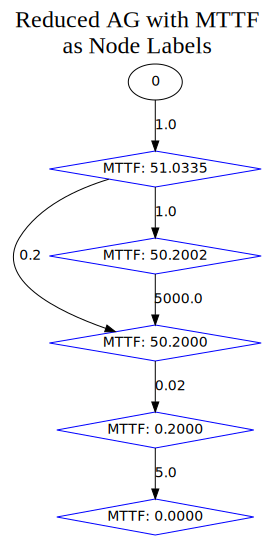

In [85]:

ag = AttackGraph()


ag.load_dot_file('/opt/projects/diss/py-mulval/data/mulval_ag/small_enterprise/AttackGraph.dot')
ag.name = 'small_enterprise'

# ag.load_score_dict('/opt/projects/diss/py-mulval/src/py_mulval/data/secmet/scoreDict_mttf.yml')
ag.load_score_dict('/opt/projects/diss/py-mulval/src/py_mulval/data/secmet/scoreDict.yml')
ag.PLOT_INTERMEDIATE_GRAPHS = False


reduced_ag = ag.getReducedGraph()

# ag.map_scores = 'cvss2effort'
ag.map_scores = 'cvss2time'
ag.score_strategy = 'reliability'

reduced_ag = ag.getReducedGraph()
# print(reduced_ag.edges(data=True))
# print(reduced_ag.nodes(data=True))

# display(plot_ag(reduced_ag, 'Reduced AG Mapped to Dacier\'s \nMTTF Transition Rates'))
print(mttf(reduced_ag))
plot_ag(reduced_ag, 'Reduced AG with MTTF \nas Node Labels')

52.033500000000004
103.06700000000001
153.267
153.46699999999998
153.46699999999998
{('0', '13', '5', '3', '1'): 153.46699999999998}
52.033500000000004
103.06700000000001
153.2672
203.4672
203.66719999999998
203.66719999999998
{('0', '13', '5', '3', '1'): 153.46699999999998, ('0', '13', '8', '5', '3', '1'): 203.66719999999998}


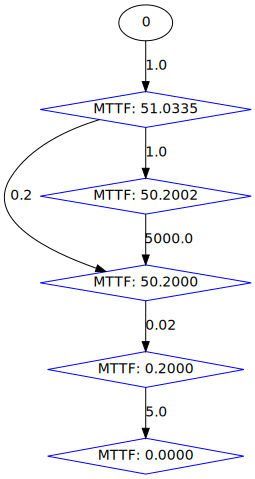

In [86]:


# origin = list(reduced_ag.getOriginnodesByAttackerLocated())[0]
origin = reduced_ag.origin
target = list(reduced_ag.getTargetByNoEgressEdges())[0]

pw_dict = {}
paths = nx.all_simple_paths(reduced_ag, origin, target)
for path in paths:
  mttf_sum = 0
  for n in path:
    mttf_sum += reduced_ag.nodes[n]['mttf']
    print(mttf_sum)
  pw_dict.update({tuple(path): mttf_sum})
  print(pw_dict)
shortest_path_length = min(pw_dict.values())
shortest_paths = [key for key in pw_dict if pw_dict[key] == shortest_path_length]
# shortest_path = nx.shortest_path(reduced_ag, origin, target, weight='mttf')
# shortest_paths = list(nx.all_shortest_paths(reduced_ag, origin, target, weight='mttf'))
# shortest_path_length =  nx.shortest_path_length(reduced_ag, origin, target, weight='mttf')
# print(shortest_path, shortest_path_length)
display(plot_ag(reduced_ag))

In [87]:
print(reduced_ag.edges(data=True))

[('3', '1', {'score': 5.0, 'weight': 5.0, 'label': 5.0}), ('5', '3', {'score': 0.02, 'weight': 0.02, 'label': 0.02}), ('8', '5', {'score': 5000.0, 'weight': 5000.0, 'label': 5000.0}), ('13', '5', {'score': 0.2, 'weight': 0.2, 'label': 0.2}), ('13', '8', {'score': 1.0, 'weight': 1.0, 'label': 1.0}), ('0', '13', {'score': 1.0, 'weight': 1.0, 'label': 1.0})]


In [88]:
print(reduced_ag.edges(data=True))

[('3', '1', {'score': 5.0, 'weight': 5.0, 'label': 5.0}), ('5', '3', {'score': 0.02, 'weight': 0.02, 'label': 0.02}), ('8', '5', {'score': 5000.0, 'weight': 5000.0, 'label': 5000.0}), ('13', '5', {'score': 0.2, 'weight': 0.2, 'label': 0.2}), ('13', '8', {'score': 1.0, 'weight': 1.0, 'label': 1.0}), ('0', '13', {'score': 1.0, 'weight': 1.0, 'label': 1.0})]


In [89]:
# import importlib
# importlib.reload(py_mulval)

# def calculate_sp(A):
#     import networkx
#     path = None
#     length = None
#     origin = A.origin
# #     origin = list(A.getOriginnodesByAttackerLocated())[0]
#     target = list(A.getTargetByNoEgressEdges())[0]
#     print(networkx.shortest_path(A,origin,target, weight='weight'))
#     print(list(networkx.all_shortest_paths(A,origin,target, weight='weight')))
#     print(networkx.shortest_path_length(A,origin,target, weight='weight'))
#     paths = list(networkx.all_simple_paths(A,origin,target))
#     return calculate_path_length(paths[0])


    
# calculate_sp(reduced_ag)


In [90]:

nodelist = reduced_ag.getNodeList(includeSource=True)
tmatrix  = nx.adjacency_matrix(reduced_ag, nodelist)
print(tmatrix.todense())
print(np.vstack((nodelist, tmatrix.todense())))

[[0.e+00 1.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+00 2.e-01 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 5.e+03 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 2.e-02 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 5.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]]
[['0' '13' '8' '5' '3' '1']
 ['0.0' '1.0' '0.0' '0.0' '0.0' '0.0']
 ['0.0' '0.0' '1.0' '0.2' '0.0' '0.0']
 ['0.0' '0.0' '0.0' '5000.0' '0.0' '0.0']
 ['0.0' '0.0' '0.0' '0.0' '0.02' '0.0']
 ['0.0' '0.0' '0.0' '0.0' '0.0' '5.0']
 ['0.0' '0.0' '0.0' '0.0' '0.0' '0.0']]


## Mean Effort to Failure (metf_ortalo_1999)
Ortalo cite{Ortalo_19999}:

Ortalo's privilege graph model assumes the probability to succeed in a given attack before expending effort $e$ is described by an exponential distribution given by: 

$P(t) = 1-exp(-\lambda e)$  

Transition rate $\lambda$ estimates the effort, with mean effort for an attack to succeed given by 

$\frac{1}{\lambda}$.

The mean effort $E_j$ spent in state $j$ is:

$E_j = 1 / \sum\limits_{i\in out(j)}\lambda_{ji}$

... and the $METF_k$ is mean time to failure when state $k$ is the initial state and $P_{k1}$ the conditional probability from state $k$ to state $1$:

$METF_k = T_k + \sum\limits_{1\in out(k)}P_{k1} ; P_{k1}=\lambda_{k1} \times E_k$


The shortest path is:

$\textbf{SP} = min(METF_k)$  for all possible paths


<class 'numpy.ndarray'>


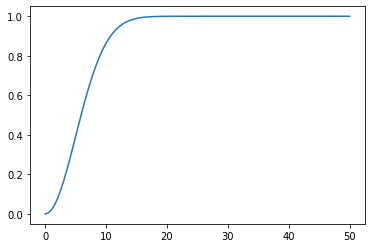

In [91]:
from scipy.stats import expon

fig, ax = plt.subplots(1, 1)

# Attack success rate levels:
# 1 is level 1 (easiest, lowest effort attack)
# .1 is level 2
# .01 is level 3
# .001 is level 4 (toughest, highest effort attack)

x = np.linspace(.0002, 50, 100)

print(type(x))
lamb = np.linspace(0.0001,.9999, 100)
# print(x)
ax.plot(x, 1 - expon.pdf(x * lamb), label='P(t)')

In [92]:


effort_dict = {(0, 2.5): 1, 
               (2.5, 5): 0.1,
               ( 5, 7.5): 0.01,
                (7.5, 10): 0.001
              }
# not using np.interp to match paper assumptions
def translate_cvss(parted_dict, score):
    for key in parted_dict:
        if key[0] <= score <= key[1]:
            return parted_dict[key]
        
vfunc = np.vectorize(translate_cvss, otypes=[float])
vfunc(effort_dict, [0,1,2,3,4,5, 6, 7, 8, 9, 10])

array([1.   , 1.   , 1.   , 0.1  , 0.1  , 0.1  , 0.01 , 0.01 , 0.001,
       0.001, 0.001])

In [93]:
np.linspace(0,10,7)

array([ 0.        ,  1.66666667,  3.33333333,  5.        ,  6.66666667,
        8.33333333, 10.        ])

# Shortest Path (Direct)



In [94]:

#     pw_dict = {}
#     paths = networkx.all_simple_paths(reduced_ag, origin, target)
#     for spath in paths:
#       for path in map(networkx.utils.pairwise, [spath]):
#         min_edge = {} # holds min {(u,v): weight} for each multi-edge pair
#         for pair in path:
#           pair_edges = reduced_ag.get_edge_data(pair[0], pair[1])
#           for k in pair_edges.keys():
#             if (pair[0], pair[1]) not in min_edge.keys() or min_edge[(pair[0], pair[1])] > pair_edges[k]['weight']:
#               min_edge[(pair[0], pair[1])] = pair_edges[k]['weight']
#       pw_dict[tuple(path)] = sum(min_edge.values())
#     shortest_path_length = min(pw_dict.values())
#     shortest_paths = [key for key in pw_dict if pw_dict[key] == shortest_path_length]

# References

<mark> <b>The bib file biblio.bib was not found

</b> </mark>(<a id="cit-Dacier_1994" href="#call-Dacier_1994">?</a>) !! _This reference was not found in biblio.bib _ !!

(<a id="cit-Dacier_1996" href="#call-Dacier_1996">?</a>) !! _This reference was not found in biblio.bib _ !!

(<a id="cit-Ortalo_19999" href="#call-Ortalo_19999">?</a>) !! _This reference was not found in biblio.bib _ !!

